# Earth Lab Spectral tools vignette

In [10]:
import hytools as ht
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

## Load Earth Lab Spectral tools

In [6]:
%load_ext autoreload
%autoreload 2
import spectral_unmixing_tools as el_spectral

print(dir(el_spectral))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['GradientBoostingRegressor', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'boosted_quantile_plot', 'boosted_quantile_plot_by_sensor', 'box', 'concatenate_sensors', 'download_neon_file', 'extract_overlapping_layers_to_2d_dataframe', 'fit_models_with_different_alpha', 'generate_configurations', 'generate_correction_configs', 'get_spectral_data_and_wavelengths', 'glob', 'gpd', 'h5py', 'ht', 'json', 'load_spectra', 'mask', 'np', 'os', 'pd', 'plot_each_sensor_with_highlight', 'plot_spectral_data', 'plot_with_highlighted_sensors', 'plt', 'prepare_spectral_data', 'process_hdf5_with_neon2envi', 'random', 'rasterio', 'rasterize', 'rasterize_polygons_to_match_envi', 'requests', 'reshape_spectra', 'run_bash_script_in_conda_env', 'show', 'subprocess']


## Get flightline from NEON

In [7]:
site_code = 'NIWO'
product_code = 'DP1.30006.001'
year_month = '2020-08'  # The specific month of interest
flight_line = 'D13_NIWO_DP1_20200801_161441'  # The exact flight line identifier

el_spectral.download_neon_file(site_code, product_code, year_month, flight_line)

Data retrieved successfully for 2020-08!


--2024-03-19 18:15:14--  https://storage.googleapis.com/neon-aop-products/2020/FullSite/D13/2020_NIWO_4/L1/Spectrometer/ReflectanceH5/2020080114/NEON_D13_NIWO_DP1_20200801_161441_reflectance.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.68.123, 142.250.188.251, 172.217.12.155, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.68.123|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 4068977853 (3.8G) [application/octet-stream]
Saving to: ‘NEON_D13_NIWO_DP1_20200801_161441_reflectance.h5’

     0K .......... .......... .......... .......... ..........  0%  582K 1h53m
    50K .......... .......... .......... .......... ..........  0%  816K 97m26s
   100K .......... .......... .......... .......... ..........  0% 1.98M 75m52s
   150K .......... .......... .......... .......... ..........  0% 2.19M 64m17s
   200K .......... .......... .......... .......... .......... 

## Convert the .h5 file to ENVI file

In [ ]:
conda_env_path = "/opt/conda/envs/macrosystems"
bash_script = "correct.sh"
h5_file = "NEON_D13_NIWO_DP1_20200801_161441_reflectance.h5"
el_spectral.sprectral_unmixing_tools.run_bash_script_in_conda_env(conda_env_path, bash_script, [h5_file], use_ancillary=True)

## Plot fresh ENVI file for quality check

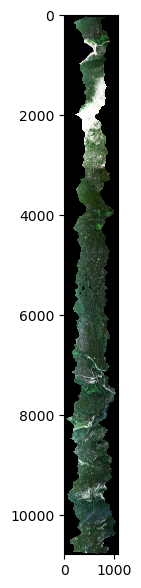

In [26]:
og_envi = ht.HyTools()
og_envi.read_file("output/NEON_D13_NIWO_DP1_20200801_161441_reflectance",'envi')
el_spectral.show_rgb(og_envi, correct= [])

## Apply corrections to flightline

### Build configuration file for corrections
This will save a json file to the flight line directory with all of the meta data and configurations necessary to caluclate the corrections in the next step. 

In [13]:
main_image_file = "NEON_D13_NIWO_DP1_20200801_161441_reflectance.h5"  # Update with your main image file path
output_dir = 'output'  # Update with your desired output directory
el_spectral.generate_correction_configs(main_image_file, output_dir)

Configuration saved to output/NEON_D13_NIWO_DP1_20200801_161441_reflectance_.json


### Apply corrections to fresh ENVI to create corrected ENVI file


In [22]:
%run  image_correct.py output/config_0.json


output/config_0.json
Using 1 CPUs.


2024-03-19 18:38:06,809	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-03-19 18:38:07,959	INFO worker.py:1673 -- Started a local Ray instance.


Calculating topographic coefficients.
Scene average solar zenith angle : 42.689 degrees
Calculating BRDF coefficients
 #################################################################################################### [100.00%]

Exporting correction coefficients.
Exporting corrected images.
(HyTools pid=70317) export/NEON_D13_NIWO_DP1_20200801_161441_reflectance
(HyTools pid=70317) export/NEON_D13_NIWO_DP1_20200801_161441_reflectance


## Quality control plots for corrections

### Method 1 - use the calculated coefficients

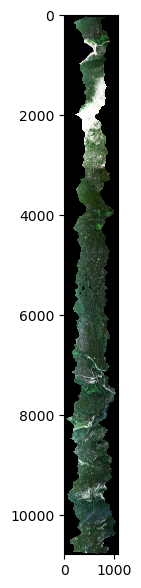

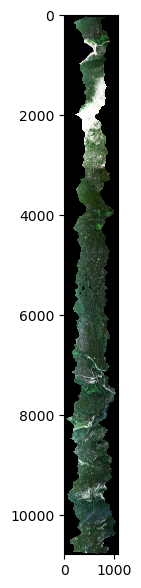

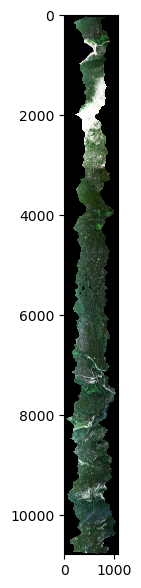

In [27]:
# Load caluclated coefficients
topo_coeffs = 'export/NEON_D13_NIWO_DP1_20200801_161441_reflectance_topo_coeffs__corrected_0.json'
envi.load_coeffs(topo_coeffs,'topo')

brdf_coeffs = 'export/NEON_D13_NIWO_DP1_20200801_161441_reflectance_brdf_coeffs__corrected_0.json'
envi.load_coeffs(brdf_coeffs,'brdf')

# Attach to original ENVI file
el_spectral.show_rgb(og_envi, correct = ['topo'])
el_spectral.show_rgb(og_envi, correct = ['brdf'])
el_spectral.show_rgb(og_envi, correct = ['topo','brdf'])


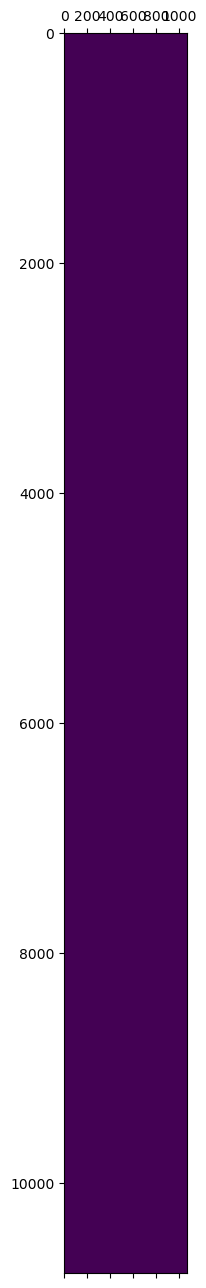

In [38]:
difference = og_envi.get_wave(2510.077393, corrections= []) - og_envi.get_wave(2510.077393, corrections= ['topo', 'brdf'])
plt.matshow(difference)





### Method 2 - use the converted ENVI files

In [ ]:
gpkg_path = 'Datasets/niwot_aop_polygons_2023_12_8_23_analysis_ready_half_diam.gpkg'
existing_raster_path = "export/ENVI__corrected_0"
output_raster_path = "output_raster.envi"

# Call the function with or without the `attribute` parameter
el_spetral.rasterize_polygons_to_match_envi(gpkg_path, existing_raster_path, output_raster_path, attribute='polygon_id')
